In [1]:
import sys
sys.path.insert(0,'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages')
sys.path.insert(0,'../')

import sxs
import spherical_functions as sf
import quaternion
import qnmfits
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0,'../qnmfits')
import read_waveforms

### The `sxs` package lets us easily load SXS waveforms:

In [3]:
h = sxs.load('SXS:BBH:0305/Lev/rhOverM', extrapolation_order=2)
type(h)

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


sxs.waveforms.waveform_modes.WaveformModes

The returned object is an sxs `WaveformModes` object. Converting to a scri `WaveformModes` object allows us to use lots of handy methods (see the `scri` documentation [here](https://scri.readthedocs.io/en/latest/_autosummary/scri.html#scri.WaveformModes)).

In [4]:
h = read_waveforms.sxs_to_scri_WM(h)
type(h)

scri.waveform_modes.WaveformModes

In [5]:
# We can also easily load metadata associated with the simulation
metadata = sxs.load('SXS:BBH:0305/Lev/metadata.json')

M = metadata.remnant_mass
chi_f = metadata.remnant_dimensionless_spin
chi = np.linalg.norm(chi_f)

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


One can also load preloaded data and metada using 
`scri.SpEC.read_from_h5('/path/to/rhOverM_Asymptotic_GeometricUnits_CoM_0305.h5/Extrapolated_N2.dir')`
and
`sxs.metadata.Metadata.from_file('/path/to/metadata_0305.txt', cache_json=False)`


Prepare the waveform for fitting by:
1) shifting the peak to be at $t=0M$,\
2) aligning the remnants spin with $+\hat{z}$, and \
3) cutting off any times in which we are not interested. 

In [6]:
# Shift peak of waveform to be at t=0M.
trim_ind = h.max_norm_index()
h.t -= h.t[trim_ind]

# If needed, rotate waveform so remnant spin is aligned with z-axis to get best fit 
th_z = np.arccos(chi_f[2]/np.linalg.norm(chi_f))
r_dir = np.cross([0,0,1],chi_f)
r_dir = th_z * r_dir / np.linalg.norm(r_dir)
q = quaternion.from_rotation_vector(-r_dir)
h.rotate_physical_system(q);

# Cut off waveform for times greater than 90M 
h_shifted = h.copy()[np.argmin(abs(h.t - 0.)):np.argmin(abs(h.t - 90))+1,:]

### Perform a seven overtone fit to the $h_{22}$ mode at $t_0 = t_{\mathrm{peak}}$ using the `qnmfits` package:

In [7]:
qnms = [(2,2,n,1) for n in range(7+1)]
t_0 = 0.

best_fit = qnmfits.fit(
    h_shifted,
    chi, 
    M,
    qnms,
    spherical_modes=[(2,2)],
    t_0=t_0
)

In [8]:
best_fit

{(2, 2, 0, 1): (0.14437528321369733+0.9515425435474294j),
 (2, 2, 1, 1): (3.06104265918855-2.7093762966259467j),
 (2, 2, 2, 1): (-10.246299728808225+3.443272406058986j),
 (2, 2, 3, 1): (20.418309082379228-6.8003534034627595j),
 (2, 2, 4, 1): (-26.115570479328504+15.832247758891933j),
 (2, 2, 5, 1): (18.147288497837422-20.107629010397105j),
 (2, 2, 6, 1): (-5.778945161817656+11.789713020711439j),
 (2, 2, 7, 1): (0.7092756681293291-2.5940446687125003j)}

From this, one can build an analytical ringdown waveform with the `best_fit` amplitudes and calculate the mismatch over all modes.

In [9]:
Q = qnmfits.qnm_modes_as(chi, M, best_fit, h_shifted, t_0=0., t_ref=0.)

In [10]:
qnmfits.mismatch(h_shifted, Q, 0., 90., spherical_modes=None)

0.29653955619237427

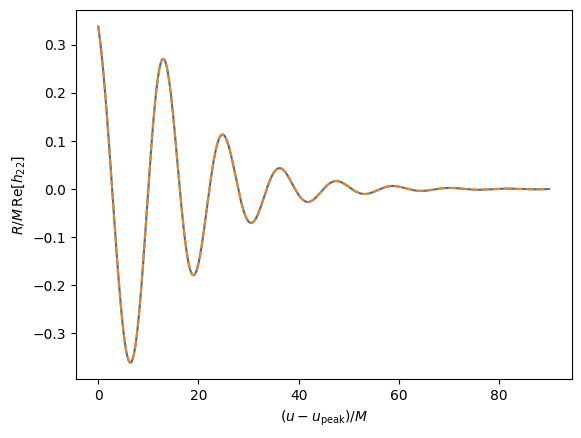

In [12]:
plt.xlabel(r'$\left(u-u_{\mathrm{peak}}\right)/M$')
plt.ylabel(r'$R/M\,\mathrm{Re}[h_{22}]$')

plt.plot(h_shifted.t, h_shifted.data[:,h_shifted.index(2,2).real])
plt.plot(Q.t, Q.data[:,Q.index(2,2)].real, '--')
plt.show()

### Perform a simultaneous fit for seven overtones and remnant spin and mass:

In [13]:
chi_fit, M_fit, qnm_fits, _ = qnmfits.fit_chi_M_and_modes(h_shifted, qnms, t_0=0., maxiter=10000, xtol=1e-8, ftol=1e-8)

In [14]:
qnm_fits

{(2, 2, 0, 1): (0.1371159369293715+0.9530714253688121j),
 (2, 2, 1, 1): (3.1535604986415953-2.71991368491889j),
 (2, 2, 2, 1): (-10.862780062699766+3.601505051527732j),
 (2, 2, 3, 1): (22.713327598649325-7.916368513428436j),
 (2, 2, 4, 1): (-30.538687542825993+19.57554423860551j),
 (2, 2, 5, 1): (22.287871717754083-25.71097920087418j),
 (2, 2, 6, 1): (-7.603241790644682+15.568527225317904j),
 (2, 2, 7, 1): (1.0526861461402912-3.5459490293882716j)}

Calculate the error as defined in Eq. 31 of https://arxiv.org/pdf/2110.15922

In [15]:
print(np.sqrt(((M_fit-M)/M)**2.0+(chi_fit-chi)**2.0))

0.0003573988563112666


Build the analytical waveform with the best fit modes and calculate the mismatch over all modes.

In [16]:
Q = qnmfits.qnm_modes_as(chi_fit, M_fit, qnm_fits, h_shifted, t_0=0., t_ref=0.)

In [17]:
qnmfits.mismatch(h_shifted, Q, 0., 90.)

0.29653967612254617